<a href="https://colab.research.google.com/github/PGM-Lab/2023-probai-private/blob/main/Day2-AfterLunch/notebooks/students_bayesian_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
Let's begin by installing and importing the modules we'll need.

In [1]:
!pip install -q pyro-ppl torch

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import types
import matplotlib.pyplot as plt
from pyro.infer import Predictive
import pyro
from pyro.distributions import Normal, Uniform, Delta, Gamma, Binomial
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import torch.distributions.constraints as constraints
import pyro.optim as optim
from pyro.contrib.autoguide import AutoNormal
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# for CI testing
pyro.set_rng_seed(1)
pyro.enable_validation(True)

# Dataset 

The following example is taken from \[1\].  We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[1\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data \[2\] and investigate this relationship.  We will be focusing on three features from the dataset:
  - `cont_africa`: whether the given nation is in Africa
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `rgdppc_2000`: Real GDP per capita for the year 2000
 
  
We will take the logarithm for the response variable GDP as it tends to vary exponentially. 

In [2]:
DATA_URL = "https://raw.githubusercontent.com/pyro-ppl/brmp/master/brmp/examples/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, (1,2)], data[:, 0]

In [3]:
# Display first 10 entries 
display(df[0:10])

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343
11,0,0.006,9.212541
12,0,0.143,10.143191
13,0,3.513,10.274632
14,0,1.672,7.852028
15,1,1.780,6.432380


In [6]:
def prepare_figure(title='Scatter plot of data', x_data_ = None, y_data_ = None):
    """
    Plot the data and return the figure axis for possible subsequent additional plotting.
    :param title: Title of the plot
    :param x_data_: Nx2 numpy array or torch tensor
    :param y_data_: Nx1 numpy array or torch tensor with the class labels.
    :return: Figure axis.
    """
    if x_data_ is None and y_data_ is None:
        x_data_ = x_data
        y_data_ = y_data

    if type(x_data_) is torch.Tensor:
        x_data_ = x_data_.numpy()
        y_data_ = y_data_.numpy()

    xx, yy = np.mgrid[np.floor(np.min(x_data_[:, 0])):np.ceil(np.max(x_data_[:, 0])):.01,
             np.floor(np.min(x_data_[:, 1])):np.ceil(np.max(x_data_[:, 1])):.01]

    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    f, ax = plt.subplots(figsize=(8, 6))
    f.suptitle(title, fontsize=16)

    ax.scatter(x_data[y_data_==0,0], x_data[y_data_==0, 1], c='g', s=50,
               edgecolor="white", linewidth=1, label='Non-African')

    ax.scatter(x_data[y_data_==1,0], x_data[y_data_==1, 1], c='orange', s=50,
               edgecolor="white", linewidth=1, label='African')

    ax.set(aspect="equal",
           xlim=(0, 7), ylim=(6, 11),
           xlabel="Rugged", ylabel="Log GDP")

    ax.legend()

    return ax, grid, xx, yy

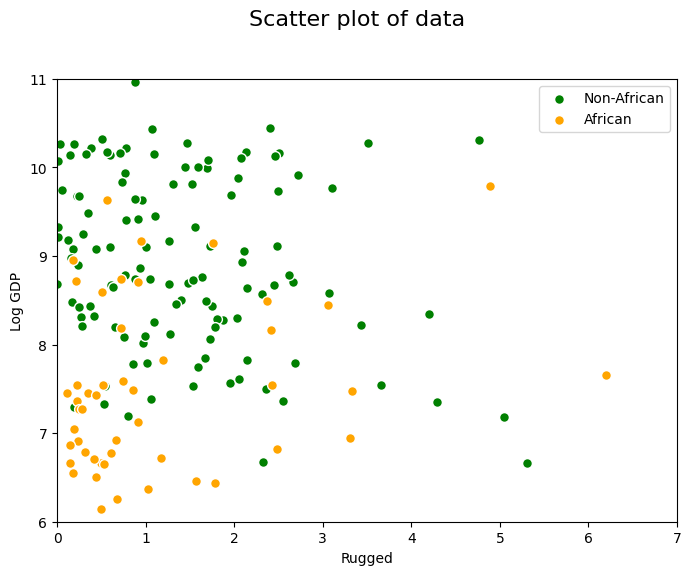

In [7]:
prepare_figure()
plt.show()

# 1. Logistic Regression

Logistic Regression is one of the most commonly used supervised learning tasksin machine learning. Suppose we're given a dataset $\mathcal{D}$ of the form

$$ \mathcal{D}  = \{ ({\bf x_i}, y_i) \} \qquad \text{for}\qquad i=1,2,...,N$$

where ${\bf X_i}\in {\mathbb R}^m$ and $y_i\in \{0,1\}$.

The goal of logistic regression is to fit a model that correctly predicts the probabilities of the class labels:

$$ p(y|x) = \frac{1}{1+e^{-b  -{\bf w}^T {\bf x} }}$$

where ${\bf w}$ and $b$ are learnable parameters. Specifically $w$ is a vector of weights and $b$ is a bias term.

First we implement a logistic regression model in PyTorch and learn point estimates for the parameters ${\bf w}$ and $b$.  Afterwards we'll see how to incorporate uncertainty into our estimates by using Pyro to doing Bayesian logistic regression.

## 1.1 Model
Using a logistic regresison model, we want to predict whether a nation is african or not as a function of the terrain rugedness index and log GDP per capita of a nation.  

Our input `x_data` is a tensor of size $N \times 2$ and our output `y_data` is a tensor of size $N \times 1$.  The method `predict(self,x_data)` defines a sigmoid transformation of the form $\mathit{sigmoid}({\bf x}^T{\bf w} + b)$, where ${\bf w}$ is the weight vector and $b$ is the additive bias.

The parameters of the model are defined using ``torch.nn.Parameter``, and will be learned during training. 

In [8]:
class LogisticRegressionModel():
    def __init__(self):
        self.w = torch.nn.Parameter(torch.zeros(1, 2))
        self.b = torch.nn.Parameter(torch.zeros(1, 1))

    def params(self):
        return {"b":self.b, "w": self.w}

    def predict(self, x_data):
        return torch.sigmoid(-self.b - torch.mm(self.w, torch.t(x_data))).squeeze(0)

    def logits(self, x_data):
        return (self.b + torch.mm(self.w, torch.t(x_data))).squeeze(0)

In [9]:
logistic_regression_model = LogisticRegressionModel()

## 1.2 Training
For training we will use the cross entropy as our loss and Adam as our optimizer. We will use a somewhat large learning rate of `0.05` and run for 1000 iterations.

In [10]:
def train(num_iterations = 1000):
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')
    optim = torch.optim.Adam(logistic_regression_model.params().values(), lr=0.05)

    for j in range(num_iterations):
        # run the model forward on the data
        logits = logistic_regression_model.logits(x_data)
        # calculate the cross-entropy loss
        loss = loss_fn(logits,y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in logistic_regression_model.params().items():
        print(name, param.data.numpy())

In [11]:
train()

[iteration 0500] loss: 70.1524
[iteration 1000] loss: 69.0927
Learned parameters:
b [[11.655147]]
w [[-0.31429428 -1.4852787 ]]


## 1.3 Evaluating the model

We now plot the decision line learned for african and non-afrian nations relating the rugeedness index with the GDP of the country.

In [ ]:
ax, grid, xx, yy = prepare_figure('Decision line')
probs = logistic_regression_model.predict(grid).reshape(xx.shape).detach().numpy()
ax.contour(xx, yy, probs, levels=[.5], cmap="Reds", vmin=0, vmax=.6)
plt.show()

# 2. Bayesian Logistic Regression


[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a _distribution_ over variables that are consistent with the observed data.

In order to make our linear regression Bayesian, we need to put priors on the parameters ${\bf w}$ and $b$. These are distributions that represent our prior belief about reasonable values for $\{bf w}$ and ${\bf b}$ (before observing any data).

A graphical representation would be as follows:

<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day3/Figures/BayesianLogisticRegressionPGM.png" width=800>


## 2.1 Model

We now have all the ingredients needed to specify our model. First we define priors over weights and bias. The prior on the intercept parameter is very flat as we would like this to be learnt from the data. We are using a weakly regularizing prior on the regression coefficients to avoid overfitting to the data.

We use the `obs` argument to the `pyro.sample` statement to condition on the observed data `y_data`.

### <span style="color:red">Exercise </span> 
 
* Define a random variable "b" to model the intercept. 
* Define the class random variable "african/non-african" for the predicited labels.
* This random variable is defined as Binomial distribution and is parametrized with the logits. 
* If time permits, explore and experiment with the notebook; e.g., specification of prior distributions, manually specified guides, and modifications to the model.

In [ ]:
def model(x_data, y_data):
    # weight and bias priors
    with pyro.plate("plate_w", 2):
        w = pyro.sample("w", Normal(torch.zeros(1,1), torch.ones(1,1)))

    # Define a random variable "b" to model the intercept.
   

    with pyro.plate("map", len(x_data)):
        # Compute logits (i.e. log p(x=0)/p(x=1)) as a linear combination between data and weights.
        logits = (b + torch.mm(x_data,torch.t(w))).squeeze(-1)
        # Define a Binomial distribution as the observed value parameterized by the logits.
        

## 2.2 Guide

In order to do inference we're going to need a guide, i.e. a variational family of distributions.  We will use Pyro's [autoguide library](https://docs.pyro.ai/en/stable/infer.autoguide.html). Under the hood, this defines a `guide` function, which in this case provides us with `Normal` variation distributions with learnable parameters, one for each sample `sample()` statement in the model.

In [ ]:
guide = AutoNormal(model)

## 2.3 Inference

To do inference we'll use stochastic variational inference (SVI). Just like in the non-Bayesian linear regression, each iteration of our training loop will take a gradient step, but now we will use the ELBO objective instead of binary cross entropy by constructing a `Trace_ELBO` object that we pass to `SVI`. 

To take an ELBO gradient step we simply call the step method of SVI. Notice that the data argument we pass to step will be passed to both model() and guide().  

In [ ]:
def train_vi(x_data, y_data, model, guide=None, num_iterations = 1000):
    optim = Adam({"lr": 0.1})

    # if no guide is provided, resort to an autoguide
    guide_ = guide if guide is not None else AutoNormal(model)

    svi = SVI(model, guide_, optim, loss=Trace_ELBO(), num_samples=10)

    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

Learn the model

In [ ]:
guide = AutoNormal(model)
train_vi(x_data, y_data, model, guide=guide)

Get the learned parameters

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.numpy())

As you can see, instead of just point estimates, we now have uncertainty estimates over our model parameters.

## 2.4 Model Evaluation: Model's Uncertainty
We will sample different logistic regression lines to see how using a Bayesian approach can capture model undertainty.

Here we again rely on Pyro's Predictive class, which allows for easy sampling of the model parameters.

In [ ]:
ax, grid, xx, yy = prepare_figure('Model evaluation')
num_samples=10
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = predictive(grid, None)

# Plot the mean decision surface 
logits = torch.mean(torch.mm(grid, torch.t(svi_samples['w'].squeeze())) + svi_samples['b'].squeeze(), axis=1).squeeze(-1)
probs = Binomial(logits = logits).mean
ax.contour(xx, yy, probs.reshape(xx.shape).detach().numpy(), levels=[.5], cmap="Reds", vmin=0, vmax=1.5)

# Sample and plot decision surfaces
for i in range(num_samples):
    logits = (torch.mm(grid, torch.t(svi_samples['w'][i,:])) + svi_samples['b'][i,:]).squeeze(-1)
    probs = Binomial(logits = logits).mean
    ax.contour(xx, yy, probs.reshape(xx.shape).detach().numpy(), levels=[.5], cmap="Greys", vmin=0, vmax=1.5)

plt.show()

The above figure shows the uncertainty in our estimate of the logistic regression line. Note that for lower values of ruggedness there are many more data points, and as such, the regression lines are less uncertainty than for high ruggness values, where there is much more uncertainty. 

## 2.5 The relationship between ruggedness and log GPD

Finally, we can look about the uncertainty about the weights associated to Terrain Rugedness and logarithm of GDP. 

Recall the learned parameters:

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.numpy())

In [ ]:
import scipy.stats as stats

f, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
for i in range(2):
    mu = pyro.param('AutoNormal.locs.w')[0,i].data.numpy().squeeze()
    std = pyro.param('AutoNormal.scales.w')[0,i].data.numpy().squeeze()
    #x = np.linspace(mu - 3*std, mu + 3*std, 100)
    x = np.linspace(-2,1, 100)
    ax[i].plot(x, stats.norm.pdf(x, mu, std))
ax[0].set_xlabel('Weight for ruggedness')
ax[1].set_xlabel('Weight for log GDP')
plt.show()

### References
  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012